In [ ]:
pip install photutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.0/857.0 kB 11.1 MB/s eta 0:00:00


In [ ]:
# Import Libraries
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from astropy.table import Table, Column
from photutils.aperture import ApertureStats
from astropy import units as u
from astropy.coordinates import SkyCoord

# Example File
filename = "Planet 1/b_e_20120620_88_1_1_1.fits"
header = (fits.open(filename)[0].header)

In [ ]:
# Open Comparative File
compfilename = 'Planet 1/ds9.tsv'

compTable = Table.read(compfilename, format='ascii.tab')

In [ ]:
rightAscension = compTable['_RAJ2000']
declination = compTable['_DEJ2000']

# Change Right Ascension and Declination into X and Y Values
sky_coords = SkyCoord(ra = rightAscension, dec = declination, unit='deg')

# Step 3: Assuming you have the FITS header information in the 'header' variable
wcs_object = WCS(header)

# Convert the celestial coordinates to pixel coordinates (X, Y)
xCoordinate, yCoordinate = wcs_object.all_world2pix(sky_coords.ra.deg, sky_coords.dec.deg, 0)

# The Number of Stars Listed
print(xCoordinate)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


[ 634.34070932  549.41065439  989.97268683  976.25220691  888.90409016
  818.01998965  849.08842361  786.65747896  682.91078556  631.58182141
  626.64302158  581.0933555   441.74634772  405.50392334  363.90843229
  302.18926308  583.44352787  563.71996215  497.03804993  494.8209566
  453.59166589  424.75779913  362.9881951   299.23294287  280.65551094
  269.84660016  239.47567429  236.34165008  150.63609075  138.18181616
   82.31131729   68.53334217  165.06379776   63.5281729  1534.16509108
 1453.28706542 1335.33906104 1342.47542192 1330.65684304 1280.85269516
 1280.2180105  1268.63585705 1174.95351304 1143.2882319  1106.84730817
 1037.66676416 1028.17748311  967.92754241  949.7682612   950.63443812
  896.73122751 1713.08241511 1419.19960773 1413.58575515 1299.81783174
 1855.47410941 1951.94841174 1897.1798627  1842.10083094 1795.21293896
 1748.32996651 1689.92049591 1630.63966069 1586.73783817 1567.10738379
 1521.99761255 1511.5572605  1470.26282056 1443.68095843 1409.03426524
 1925.6

In [ ]:
print(yCoordinate)
print(len(yCoordinate))

[ 120.98232937  227.71059226  125.66274202   12.38970695   82.98146069
   51.34811363  391.84966785  280.27786002  326.07443089  213.09554213
  198.29638587  292.15575844  263.98895341  274.47322615  366.28979927
  375.43295947  548.01143253  481.17895326  447.04388939  624.57345965
  649.16281726  532.84912441  518.59690174  772.06113754  568.41751354
  581.49790277  761.98716818  743.9990704   654.35255293  792.89865927
  797.20484129  782.21205587  948.91953015 1000.11061448  208.00139003
  133.44515502   81.87436311  386.96934853  233.25366806  419.21584952
  151.6931438    75.64093666  298.92855663  328.23922339  424.91000225
  382.49375461  537.76873129  667.91562436  474.91116934  632.00223142
  419.10783004  553.48401645  595.17238308  528.57675593  576.22825461
  483.20682644  694.18312897  766.24515584  566.90510394  831.18509804
  748.85392851  670.72246949  961.11612547  910.31569465 1087.80892353
  971.60005677 1029.81479693  964.74735618  975.30341018  961.76044154
  979.

In [ ]:
# Initialize Magnitude Values
rMag = np.array(compTable['Rmag'])

In [ ]:
def aperturePhotometry(filename, xpos, ypos):
  image = fits.getdata(filename)

  # bkg_mean, bkg_median, bkg_std = sigma_clipped_stats(image, sigma=3.0, maxiters=5)

  # Assume an Aperture Radius (Drawing it on the Scatterplot)
  apertureRadius = 10
  radius_in = 11
  radius_out = 17

  starapertures = CircularAperture((xpos, ypos), r=apertureRadius)
  phot_apers = [starapertures]
  phot_table = aperture_photometry(image, phot_apers)
  aperture_sum1 = phot_table['aperture_sum_0']

  # Annulus Aperture
  aperture_annu = CircularAnnulus([xpos, ypos], radius_in, radius_out)
  phot_table_annu = ApertureStats(image, aperture_annu)
  aperture_med2 = phot_table_annu.median

  sky_subtracted = (aperture_sum1 - aperture_med2*np.pi*apertureRadius**2)[0]

  return(sky_subtracted)

In [ ]:
target_star_loc = 98

target_aper_sum = aperturePhotometry(filename, xCoordinate[target_star_loc], yCoordinate[target_star_loc])

print(target_aper_sum)

246948.21979449503


In [ ]:
# Get the 'GAIN' and 'EXPTIME' header values and convert them to appropriate numeric types
gain = float(header['GAIN'])
exptime = float(header['EXPTIME'])

# Calculate the flux using the numeric 'GAIN' and 'EXPTIME' values (for one data file with all stars)
flux = gain * target_aper_sum / exptime

print(flux)

64206.537146568706


In [ ]:
def convert_flux(filename, rawMagnitude):
  counts = np.array(rawMagnitude)
  header = header = (fits.open(filename)[0].header)

  # Get the 'GAIN' and 'EXPTIME' header values and convert them to appropriate numeric types
  gain = float(header['GAIN'])
  exptime = float(header['EXPTIME'])

  # Calculate the flux using the numeric 'GAIN' and 'EXPTIME' values (for one data file with all stars)
  flux = gain * counts / exptime

  return flux

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astro

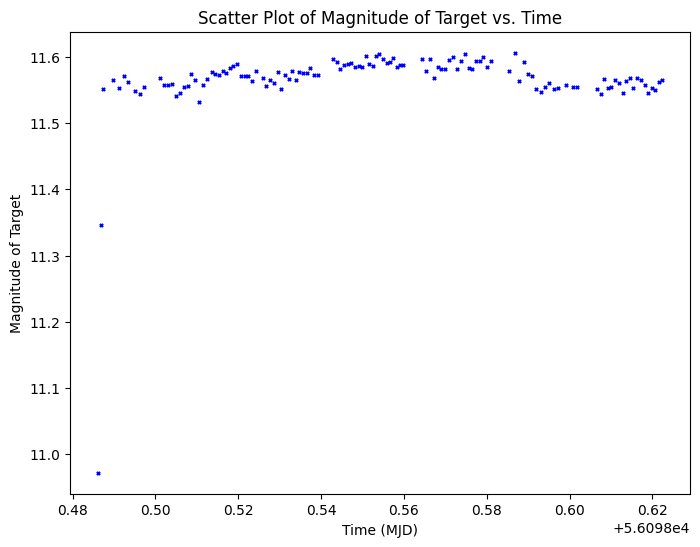

In [ ]:
# Find the Julian Date of Data to retrieve Time
fileStart = 'b_e_20120620_'
fileStartNum = 76
fileEndNum = 201
fileEnd = '_1_1_1.fits'

# Initialize Lists
filenames = []
timeArr = []
magArr = []
aperSum = []
zeroPointMed = []
fluxArr = []

# Loop through files and extract data efficiently
for i in range(fileStartNum, fileEndNum + 1):
    fileName = f'/content/Planet 1/{fileStart}{i}{fileEnd}'
    filenames.append(fileName)

    with fits.open(fileName) as data:
        time = data[0].header['MJD']
        timeArr.append(time)

        rightAscension = compTable['_RAJ2000']
        declination = compTable['_DEJ2000']

        # Change Right Ascension and Declination into X and Y Values
        sky_coords = SkyCoord(ra = rightAscension, dec = declination, unit='deg')

        # Step 3: Assuming you have the FITS header information in the 'header' variable
        wcs_object = WCS(data[0].header)

        # Convert the celestial coordinates to pixel coordinates (X, Y)
        xCoordinate, yCoordinate = wcs_object.all_world2pix(sky_coords.ra.deg, sky_coords.dec.deg, 0)

        targetValue = 98
        aperSum.append(aperturePhotometry(fileName, xCoordinate[targetValue], yCoordinate[targetValue]))

        target_flux = convert_flux(fileName, aperSum[-1])
        fluxArr.append(target_flux)

        # # Calculate Photometric Zero Point with Flux and rMag Formula With Comparison Star
        zeroPoint = []
        for (comp_star_loc) in range(30):
          comp_aper_sum = aperturePhotometry(fileName, xCoordinate[comp_star_loc], yCoordinate[comp_star_loc])
          comp_flux = convert_flux(fileName, comp_aper_sum)
          zero_point = rMag[comp_star_loc] + 2.5*(np.log10(comp_flux))
          zeroPoint.append(zero_point)

        # Append Median Value for Each File
        zero_point_median = np.nanmedian(zeroPoint)
        zeroPointMed.append(zero_point_median)

        # Find the Magnitude Given the Zero Point for Target Star
        magArr.append(zero_point_median - 2.5*np.log10(target_flux))

# data_table = Table([filenames, timeArr, magArr], names=['Filename', 'Time', 'Magnitude'])

# Set the figure size (width, height) in inches
plt.figure(figsize=(8, 6))

# Create a scatter plot
plt.scatter(timeArr, magArr, marker='x', color='blue', s=5)

# Add labels and title
plt.xlabel('Time (MJD)')
plt.ylabel('Magnitude of Target')
plt.title('Scatter Plot of Magnitude of Target vs. Time')

# Show the plot
plt.show()

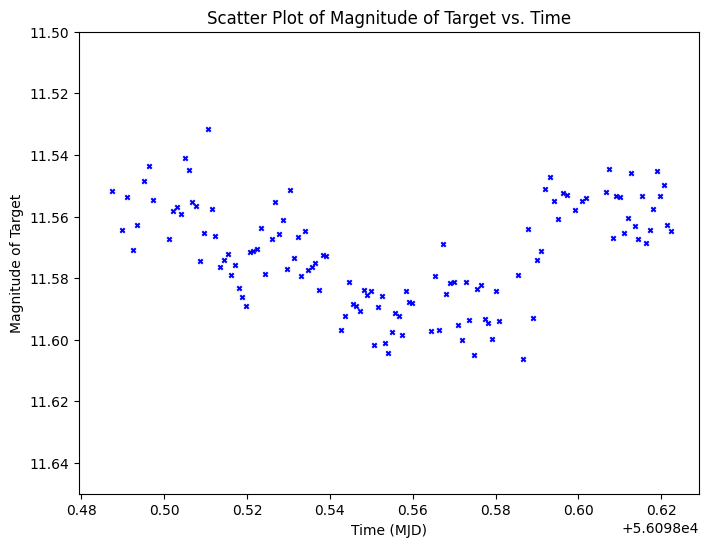

In [ ]:
# Set the figure size (width, height) in inches
plt.figure(figsize=(8, 6))

# Create a scatter plot
plt.scatter(timeArr, magArr, marker='x', color='blue', s=10)

# Add labels and title
plt.xlabel('Time (MJD)')
plt.ylabel('Magnitude of Target')
plt.title('Scatter Plot of Magnitude of Target vs. Time')

plt.ylim(11.65, 11.5)

# Show the plot
plt.show()

(2.25e-05, 2.5e-05)

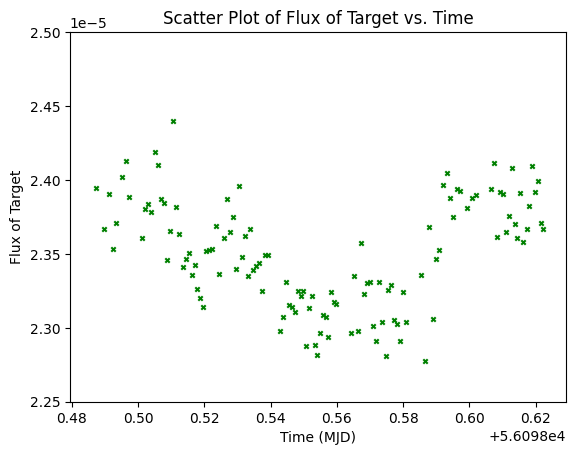

In [ ]:
magArr = np.array(magArr)

fluxTarg = 10**(magArr / - 2.5)

plt.scatter(timeArr, fluxTarg, marker='x', color='green', s=10)

# Add labels and title
plt.xlabel('Time (MJD)')
plt.ylabel('Flux of Target')
plt.title('Scatter Plot of Flux of Target vs. Time')

plt.ylim(2.25e-05, 2.5e-05)


9.9281740938799e-06
9.656604016577505e-06


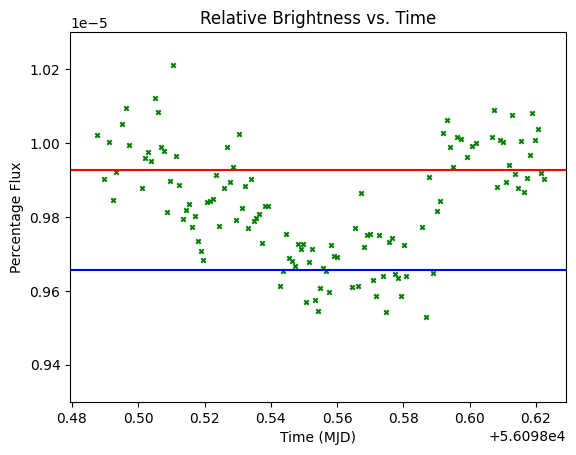

In [ ]:
percentArr = fluxTarg / 2.39

plt.scatter(timeArr, percentArr, marker='x', color='green', s=10)

# Add labels and title
plt.xlabel('Time (MJD)')
plt.ylabel('Percentage Flux')
plt.title('Relative Brightness vs. Time')

plt.ylim(0.93e-5, 1.03e-5)

sum = 0
sum1 = 0
num = 0
num1 = 0

for percent in percentArr:
    if (percent > 0.985e-5 and percent < 1.00e-5):
      num += 1
      sum += percent
    elif (percent < 0.975e-5 and percent > 0.95e-5):
      num1 += 1
      sum1 += percent

avgH = sum / num
print(avgH)
avgL = sum1 / num1
print(avgL)

plt.axhline(y=avgH, color='r', linestyle='-')
plt.axhline(y=avgL, color='b', linestyle='-')
